In [ ]:
!pip install torch==2.2.0 torchtext==0.17.0
!pip install portalocker==3.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 834.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('/content/idlmam.py')
from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from idlmam import set_seed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View,LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-16-baeeeeff9ffc>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [ ]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torchtext
import portalocker
from torchtext.datasets import AG_NEWS
train_iter, test_iter = AG_NEWS(root='./', split=('train', 'test'))
train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [ ]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
# Tokenizer
tokenizer = get_tokenizer('basic_english')
# Menghitung frekuensi token dari dataset
def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)
# Buat vocabulary dari iterator token
vocab = build_vocab_from_iterator(
yield_tokens(train_dataset),
specials=['<unk>', '<BOS>', '<EOS>', '<PAD>']
)
vocab.set_default_index(vocab['<unk>'])
print(f"Jumlah kata dalam vocab: {len(vocab)}")
print(f"Contoh indeks kata 'data': {vocab['data']}")

Jumlah kata dalam vocab: 95814
Contoh indeks kata 'data': 268


In [ ]:
def text_transform(x): #string -> list of integers
  return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] +[vocab['<EOS>']]

def label_transform(x):
  return x-1 #labes are originally [1, 2, 3, 4] but we need them as
#Transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 434, 428, 4, 1608, 14841, 116, 69, 5, 851, 16, 30, 17, 30, 18, 50728, 6, 434, 377, 19, 12, 67510, 9, 52261, 6, 45, 4012, 786, 328, 4, 2]


In [ ]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)
padding_idx = vocab["<PAD>"]
embed_dim = 128
B = 64
epochs = 5

Vocab:  95814
Num Classes:  4


In [ ]:
def pad_batch(batch):
  labels = [label_transform(z[0]) for z in batch] #label in the batch
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
#what is the longest sequence in this batch?
  max_len = max([text.size(0) for text in texts])
  texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
#make x and y a single tensor
  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
  return x, y

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [ ]:
loss_func = nn.CrossEntropyLoss()


In [ ]:
class EmbeddingAttentionBag(nn.Module):
  def __init__(self, vocab_size, D, embd_layers=3, padding_idx=None):
    super(EmbeddingAttentionBag, self).__init__()
    self.padding_idx = padding_idx
    self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
    if isinstance(embd_layers, int):
      self.embd_layers = nn.Sequential( #(B, T, D) -> (B, T, D)
          *[nn.Sequential(nn.Linear(D, D), # Use D instead of embed_dim
                          nn.LeakyReLU()) for _ in range(embd_layers)]
      )
    else:
      self.embd_layers = embd_layers
    self.attn = AttentionAvg(AdditiveAttentionScore(D))

  def forward(self, input):
    """
    input: (B, T) shape, dtype=int64
    output: (B, D) shape, dtype=float32
    """
    if self.padding_idx is not None:
      mask = input != self.padding_idx
    else:
      mask = input == input #All entries are `True`
    x = self.embd(input) #(B, T, D)
    x = self.embd_layers(x)#(B, T, D)
    #average over time
    context = x.sum(dim=1)/(mask.sum(dim=1).unsqueeze(1)+1e-5)
    return self.attn(x, context, mask=mask)

In [ ]:
#Now we can define a simple model!
# Definisi model
attnEmbd = nn.Sequential(
    EmbeddingAttentionBag(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),  # (B, T) -> (B, D)
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),
    nn.BatchNorm1d(embed_dim),
    nn.Linear(embed_dim, NUM_CLASS)
)
attnEmbd_results = train_network(
    attnEmbd,
    loss_func=torch.nn.CrossEntropyLoss(),  # Fungsi loss (contoh CrossEntropy)
    train_loader=train_loader,
    val_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=epochs
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='val Accuracy'>

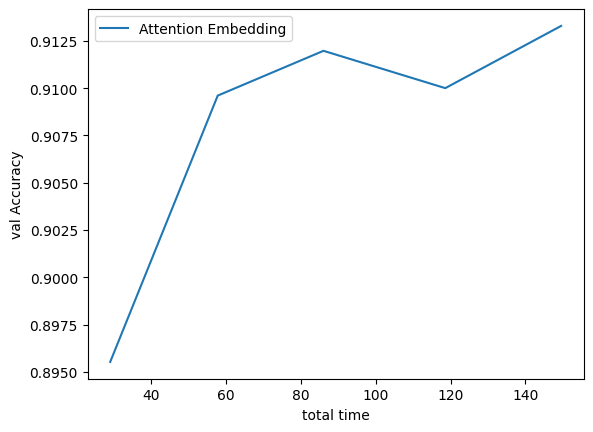

In [ ]:
sns.lineplot(x='total time', y='val Accuracy', data=attnEmbd_results, label='Attention Embedding')

 Pada awal waktu (sekitar 40), akurasi validasi cukup rendah (~0.895). Ini menunjukkan bahwa model memulai dengan performa yang relatif sederhana dan meningkat. Secara keseluruhan, Attention Embedding menunjukkan performa yang konsisten, dengan tren peningkatan akurasi validasi hingga akhir pelatihan. Grafik ini menunjukkan pentingnya memperhatikan durasi pelatihan untuk mencapai potensi maksimal model.

# Positional

In [ ]:
class PositionalEncoding(nn.Module):
  r"""Inject some information about the relative or absolute position of the tokens
      in the sequence. The positional encodings have the same dimension as
      the embeddings, so that the two can be summed. Here, we use sine and cosine
      functions of different frequencies.
      .. math::
      \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
      \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
      \text{where pos is the word position and i is the embed idx)
      Args:
      d_model: the embed dim (required).
      dropout: the dropout value (default=0.1).
      max_len: the max. length of the incoming sequence (default=5000).
      Examples:
      >>> pos_encoder = PositionalEncoding(d_model)
  """
  def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.d_model = d_model

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)
    self.batch_first = batch_first

  def forward(self, x):
      r"""Inputs of forward function
      Args:
        x: the sequence fed to the positional encoder model (required).
      Shape:
        x: [sequence length, batch size, embed dim]
        output: [sequence length, batch size, embed dim]
      Examples:
        >>> output = pos_encoder(x)
      """
      if self.batch_first: #go from (B, T, D) input shape to (T, B, D)
        x = x.permute(1, 0, 2)
      x = x *np.sqrt(self.d_model) + self.pe[:x.size(0), :]
      x = self.dropout(x)
      if self.batch_first: #now go back to (B, T, D) shape
        x = x.permute(1, 0, 2)
      return(x)

In [ ]:
simplePosEmbdAvg = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B,T, D)
  PositionalEncoding(embed_dim, batch_first=True),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.AdaptiveAvgPool2d((1,None)), #(B, T, D) -> (B, 1, D)
  nn.Flatten(), #(B, 1, D) -> (B, D)
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

In [ ]:
class EmbeddingAttentionBag(nn.Module):

  def __init__(self, vocab_size, D, embd_layers=3, padding_idx=None):
    super(EmbeddingAttentionBag, self).__init__()
    self.padding_idx = padding_idx
    self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
    if isinstance(embd_layers, int):
      self.embd_layers = nn.Sequential( #(B, T, D) -> (B, T, D)
        *[nn.Sequential(nn.Linear(embed_dim, embed_dim),
        nn.LeakyReLU()) for _ in range(embd_layers)]
      )
    else:
      self.embd_layers = embd_layers
    self.attn = AttentionAvg(AdditiveAttentionScore(D))# functions defined back in Chapter 10
  def forward(self, input):
    """
    input: (B, T) shape, dtype=int64
    output: (B, D) shape, dtype=float32
    """
    if self.padding_idx is not None:
      mask = input != self.padding_idx
    else:
      mask = input == input #All entries are `True`
    #mask is shape (B, T)
    x = self.embd(input) #(B, T, D)
    x = self.embd_layers(x)#(B, T, D)
    #average over time
    context = x.sum(dim=1)/(mask.sum(dim=1).unsqueeze(1)+1e-5) #(B, T, D) -> (B, D)
    #If we wanted to just do normal averaging, we could return the context variable right now!
    return self.attn(x, context, mask=mask) # ((B, T, D), (B, D)) -> (B, D)

In [ ]:
embd_layers = nn.Sequential( #(B, T, D) -> (B, T, D)
  *([PositionalEncoding(embed_dim, batch_first=True)]+
   [nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.LeakyReLU()) for _ in range(3)])
)
attnPosEmbd = nn.Sequential(
  EmbeddingAttentionBag(VOCAB_SIZE, embed_dim, padding_idx=padding_idx,embd_layers=embd_layers), #(B, T) -> (B, D)
  nn.Linear(embed_dim, embed_dim),
  nn.LeakyReLU(),
  nn.BatchNorm1d(embed_dim),
  nn.Linear(embed_dim, NUM_CLASS)
)

posEmbdAvg_results = train_network(simplePosEmbdAvg, loss_func, train_loader, val_loader=test_loader,
                                   score_funcs={'Accuracy': accuracy_score},
                                   device=device, epochs=epochs)
attnPosEmbd_results = train_network(attnPosEmbd, loss_func, train_loader,
                                    val_loader=test_loader, score_funcs={'Accuracy': accuracy_score},
                                    device=device, epochs=epochs)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='val Accuracy'>

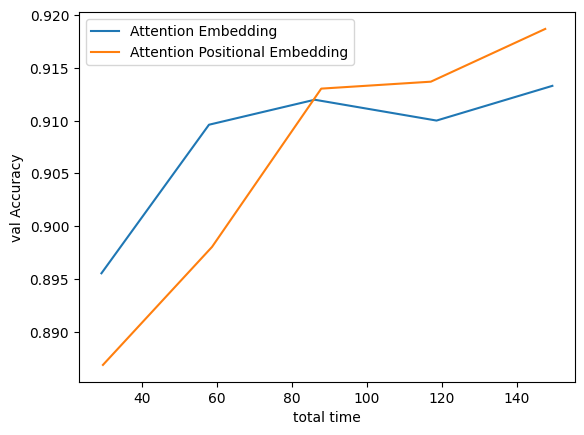

In [ ]:


sns.lineplot(x='total time', y='val Accuracy', data=attnEmbd_results, label='Attention Embedding')
sns.lineplot(x='total time', y='val Accuracy', data=attnPosEmbd_results, label='Attention Positional Embedding')

Attention Positional Embedding menunjukkan performa yang lebih baik pada waktu total lebih besar, meskipun awalnya kalah dari Attention Embedding. Ini mengindikasikan bahwa penggunaan informasi posisi mungkin lebih efektif dalam meningkatkan akurasi validasi setelah waktu tertentu.

## Transformer 2

In [ ]:
class DotProductAttention(nn.Module):

  def __init__(self, vocab_size, D, padding_idx=None):
    super(SimpleTransformerClassifier, self).__init__()
    self.padding_idx = padding_idx
    self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
    self.position = PositionalEncoding(D, batch_first=True)
    #This below line is the main work for our transformer implementation!
    self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=D, nhead=4),
                                             num_layers=8)
    self.attn = AttentionAvg(DotScore(D))
    self.pred = nn.Sequential(
      nn.Flatten(), #(B, 1, D) -> (B, D)
      nn.Linear(D, D),

      nn.LeakyReLU(),
      nn.BatchNorm1d(D),
      nn.Linear(D, NUM_CLASS)
    )
  def forward(self, input):
    if self.padding_idx is not None:
      mask = input != self.padding_idx
    else:
      mask = input == input #All entries are `True`
    x = self.embd(input) #(B, T, D)
    x = self.position(x) #(B, T, D)
    #Because the resut of our code is (B, T, D), but transformers
    #take input as (T, B, D), we will have to permute the order
    #of the dimensions before and after
    x = self.transformer(x.permute(1,0,2)) #(T, B, D)
    x = x.permute(1,0,2) #(B, T, D)
    #average over time
    context = x.sum(dim=1)/mask.sum(dim=1).unsqueeze(1)
    return self.pred(self.attn(x, context, mask=mask))


In [ ]:
#Build and train this model!
simpleTransformer = SimpleTransformerClassifier(VOCAB_SIZE, embed_dim,
                                                padding_idx=padding_idx)
transformer_results = train_network(simpleTransformer, loss_func, train_loader,
                                    val_loader=test_loader, score_funcs={'Accuracy': accuracy_score},
                                    device=device, epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='val Accuracy'>

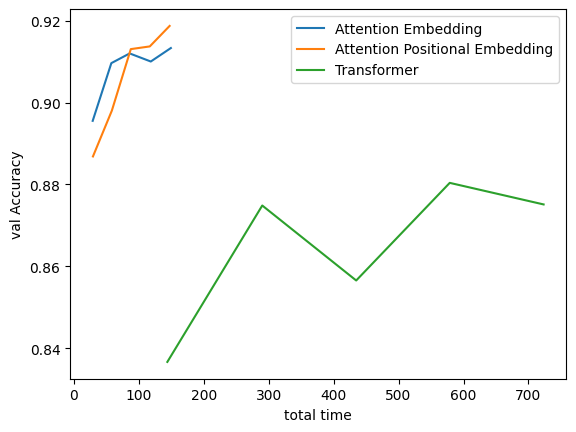

In [ ]:
sns.lineplot(x='total time', y='val Accuracy', data=attnEmbd_results, label='Attention Embedding')
sns.lineplot(x='total time', y='val Accuracy', data=attnPosEmbd_results,label='Attention Positional Embedding')
sns.lineplot(x='total time', y='val Accuracy', data=transformer_results, label='Transformer')

dari grafik menunjukan Attention Embedding,Attention Positional Embedding,Transformer bahwa Attention Positional Embedding lebih baik dari tingkat akurasi lebih tinggi dan waktu lebih cepat dibawah 200 dibandingkan transformer diangka 700 an dari total waktu

#  Experiment 3

In [ ]:
embed_dim = 256
B = 300
epochs = 5

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [ ]:
class SimpleTransformerClassifier(nn.Module):

  def __init__(self, vocab_size, D, padding_idx=None):
    super(SimpleTransformerClassifier, self).__init__()
    self.padding_idx = padding_idx
    self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
    self.position = PositionalEncoding(D, batch_first=True)
    #This below line is the main work for our transformer implementation!
    self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=D, nhead=4),
                                             num_layers=6)
    self.attn = AttentionAvg(DotScore(D))
    self.pred = nn.Sequential(
      nn.Flatten(), #(B, 1, D) -> (B, D)
      nn.Linear(D, D),

      nn.LeakyReLU(),
      nn.BatchNorm1d(D),
      nn.Linear(D, NUM_CLASS)
    )
  def forward(self, input):
    if self.padding_idx is not None:
      mask = input != self.padding_idx
    else:
      mask = input == input #All entries are `True`
    x = self.embd(input) #(B, T, D)
    x = self.position(x) #(B, T, D)
    #Because the resut of our code is (B, T, D), but transformers
    #take input as (T, B, D), we will have to permute the order
    #of the dimensions before and after
    x = self.transformer(x.permute(1,0,2)) #(T, B, D)
    x = x.permute(1,0,2) #(B, T, D)
    #average over time
    context = x.sum(dim=1)/mask.sum(dim=1).unsqueeze(1)
    return self.pred(self.attn(x, context, mask=mask))

#Build and train this model!
simpleTransformer = SimpleTransformerClassifier(VOCAB_SIZE, embed_dim,
                                                padding_idx=padding_idx)
transformer_results1 = train_network(simpleTransformer, loss_func, train_loader,
                                    val_loader=test_loader, score_funcs={'Accuracy': accuracy_score},
                                    device=device, epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='val Accuracy'>

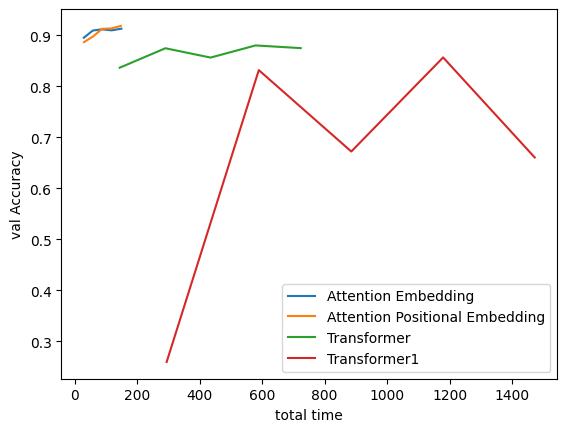

In [ ]:
sns.lineplot(x='total time', y='val Accuracy', data=attnEmbd_results, label='Attention Embedding')
sns.lineplot(x='total time', y='val Accuracy', data=attnPosEmbd_results,label='Attention Positional Embedding')
sns.lineplot(x='total time', y='val Accuracy', data=transformer_results, label='Transformer')
sns.lineplot(x='total time', y='val Accuracy', data=transformer_results1, label='Transformer1')

dikarenakan loading dari grafik menunjukan Attention Embedding,Attention Positional Embedding,Transformer bahwa Attention Positional Embedding lebih baik dari tingkat akurasi lebih tinggi dan waktu lebih cepat dibawah 200 dibandingkan transformer1(yang dimodif sendiri) diangka 1400 an dari total waktu.